In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg

import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import datetime

from tqdm.auto import tqdm

plt.style.use('ggplot')

# **Задание 1**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

reg_data - данные о времени регистрации; auth_data - данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Для начала необходимо считать предоставленные данные и ознакомиться с содержанием датафреймов

In [ ]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')

reg_data.head()

In [3]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')

auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Проводим анализ данных: оцениваем размеры датафреймов, типы данных, наличие пропущенных значений, уникальность пользователей и статистическое описание

In [4]:
reg_data.shape

(1000000, 2)

In [5]:
auth_data.shape

(9601013, 2)

In [6]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [7]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [8]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [11]:
reg_data.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [12]:
auth_data.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


*По результатам анализа можно сделать вывод о том, что датафреймы корректны, не содержат пропущенных значений, уникальность пользователей соблюдена. Для удобства дальнейшей работы необходимо привести дату к формату datetime.*

In [67]:
def retention(reg, auth, start, end):
    
# cкопируем датафреймы, чтобы функция не меняла исходные данные    
    reg2 = reg.copy()
    auth2 = auth.copy()

# поменяем unix timestamp в human-readable формат, преобразуем в дни и переименуем колонки
    reg2['reg_ts'] = pd.to_datetime(reg2.reg_ts, unit='s').dt.to_period('D')
    reg2 = reg2.rename(columns={"reg_ts": "registration"})
    
    auth2['auth_ts'] = pd.to_datetime(auth2.auth_ts, unit='s').dt.to_period('D')
    auth2 = auth2.rename(columns={"auth_ts": "authorization"})
    
# выберем данные за нужный период
    df_reg = reg2.query('registration >= @start and registration <= @end')
    df_auth = auth2.query('authorization >= @start and authorization <= @end')
    
# объединим два датафрейма в один
    df_auth_reg = df_auth.merge(df_reg, how='left', on='uid')
    
# в получившимся датафрейме есть авторизации юзеров, зарегистрировавшихся до начала нужного нам перода.
# уберем эти авторизации из исследуемых данных.
    df_cleared = df_auth_reg.dropna(axis=0, how='any')

# посчитаем разницу в днях между регистрацией и аутентификацией и преобразуем результат в целое число
    df_cleared['days'] = df_cleared.authorization - df_cleared.registration
    df_cleared['days'] = df_cleared.days.apply(lambda x: x.n)
    
# сгруппируем когорты
    df_cohorts = df_cleared\
        .groupby(['registration', 'days'], as_index=False)\
        .nunique('uid')\
        .rename(columns={"uid": "user_count"})

# создадим сводную таблицу
    pivot_df = df_cohorts.pivot(index='registration', columns='days', values='user_count')
    
# рассчитаем retention
    users_retention = pivot_df.divide(pivot_df[0], axis=0)

# добавим столбец с данными о размере каждой когорты
    users_retention.insert(0, "cohort_size", pivot_df[0], False)
    
# удалим столбец за нулевой день
    del users_retention[users_retention.columns[1]]
    
# визуализация
    ur_style = (users_retention
                .style
                .set_caption('User retention')  # добавляем подпись
                .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
                .highlight_null('white')  # делаем белый фон для значений NaN
                .format("{:.2%}", na_rep="")  # числа форматируем как проценты, NaN заменяем на пустоту
                .format(formatter={('cohort_size'): "{:.0f}"}))  # столбец с размерами когорт форматируем как числа

    return ur_style

Тестируем работу функции на 3 рандомных промежутках

In [14]:
user_retention_1 = retention(reg_data, auth_data, '2020-03-01', '2020-03-08')

user_retention_1

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


days,cohort_size,1,2,3,4,5,6,7
registration,,,,,,,,
2020-03-01,1172,1.96%,4.44%,4.86%,5.20%,4.61%,6.83%,5.20%
2020-03-02,1173,1.36%,3.67%,4.18%,4.94%,6.73%,6.05%,
2020-03-03,1176,2.38%,2.98%,4.85%,4.34%,5.36%,,
2020-03-04,1177,2.63%,4.50%,6.63%,5.18%,,,
2020-03-05,1180,2.88%,4.66%,4.58%,,,,
2020-03-06,1181,1.52%,3.56%,,,,,
2020-03-07,1183,2.03%,,,,,,
2020-03-08,1185,,,,,,,


In [15]:
user_retention_2 = retention(reg_data, auth_data, '2020-04-01', '2020-04-30')

user_retention_2

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


days,cohort_size,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
registration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,1233,1.87%,3.97%,2.84%,5.52%,5.19%,8.11%,5.03%,4.06%,3.89%,5.60%,4.70%,4.30%,4.87%,4.79%,4.06%,4.79%,4.54%,4.30%,3.49%,4.46%,3.81%,3.97%,4.14%,3.41%,3.33%,3.41%,3.73%,2.35%,4.22%
2020-04-02,1235,1.94%,5.18%,5.43%,5.59%,6.96%,7.77%,6.23%,5.99%,5.18%,5.26%,6.56%,5.99%,5.26%,5.10%,4.37%,4.78%,5.34%,4.70%,3.97%,3.81%,3.81%,4.53%,3.16%,4.05%,4.05%,3.72%,3.56%,2.27%,
2020-04-03,1237,2.75%,5.01%,5.34%,6.06%,6.14%,7.28%,7.03%,5.42%,6.22%,3.64%,5.98%,5.50%,6.79%,5.09%,5.17%,5.17%,4.20%,4.61%,4.53%,4.69%,4.37%,4.20%,5.25%,3.23%,3.64%,4.93%,2.99%,,
2020-04-04,1239,2.66%,4.52%,3.95%,5.49%,7.51%,6.46%,6.54%,4.92%,4.92%,5.41%,6.30%,4.44%,5.00%,4.28%,4.68%,4.68%,4.28%,4.44%,5.17%,4.20%,4.76%,3.31%,4.60%,2.82%,2.99%,3.55%,,,
2020-04-05,1241,2.82%,4.35%,5.00%,4.67%,6.61%,7.17%,5.72%,4.83%,5.56%,5.32%,5.88%,4.67%,5.80%,5.32%,4.35%,5.48%,3.95%,4.67%,4.59%,4.11%,3.87%,4.92%,3.95%,3.71%,3.63%,,,,
2020-04-06,1243,1.85%,4.59%,4.99%,5.15%,4.67%,7.24%,5.31%,4.91%,5.39%,4.59%,4.75%,4.02%,4.83%,4.51%,4.91%,5.39%,3.94%,4.10%,3.22%,3.86%,3.38%,4.59%,2.74%,3.70%,,,,,
2020-04-07,1245,1.85%,4.26%,4.66%,4.50%,6.02%,7.95%,5.46%,4.66%,4.10%,5.30%,5.94%,4.02%,5.06%,4.90%,4.34%,3.94%,3.61%,3.86%,3.94%,4.10%,3.37%,3.78%,3.53%,,,,,,
2020-04-08,1248,1.44%,4.57%,4.89%,5.69%,6.41%,6.17%,5.61%,5.37%,5.13%,4.81%,5.13%,5.29%,4.49%,5.21%,4.33%,4.81%,4.65%,3.77%,4.01%,4.09%,3.85%,4.25%,,,,,,,
2020-04-09,1249,1.92%,4.96%,4.64%,4.64%,5.92%,7.05%,6.49%,5.04%,5.60%,5.60%,5.44%,5.84%,4.88%,5.20%,4.40%,4.48%,5.20%,4.40%,4.48%,3.20%,4.08%,,,,,,,,


In [16]:
user_retention_3 = retention(reg_data, auth_data, '2020-01-01', '2020-01-15')

user_retention_3

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


days,cohort_size,1,2,3,4,5,6,7,8,9,10,11,12,13,14
registration,,,,,,,,,,,,,,,
2020-01-01,1061,2.64%,4.52%,3.39%,5.66%,5.84%,7.54%,5.00%,4.43%,4.43%,5.37%,6.50%,4.62%,4.90%,4.81%
2020-01-02,1063,2.35%,4.52%,5.17%,4.80%,5.83%,7.71%,5.93%,5.64%,5.27%,5.64%,5.64%,4.52%,4.52%,
2020-01-03,1065,2.35%,3.38%,4.41%,4.51%,6.85%,7.51%,5.45%,4.51%,4.23%,5.26%,5.82%,5.54%,,
2020-01-04,1067,1.50%,4.50%,5.06%,5.34%,5.72%,7.03%,5.44%,4.22%,4.87%,4.78%,5.44%,,,
2020-01-05,1069,1.96%,4.49%,4.58%,4.40%,4.77%,7.86%,5.24%,3.93%,5.43%,4.12%,,,,
2020-01-06,1070,2.90%,4.49%,4.95%,3.83%,4.67%,6.64%,5.89%,5.23%,5.05%,,,,,
2020-01-07,1072,1.87%,4.85%,4.38%,6.44%,5.04%,8.49%,5.13%,5.69%,,,,,,
2020-01-08,1074,2.23%,4.00%,4.28%,5.12%,5.03%,8.47%,5.03%,,,,,,,
2020-01-09,1076,1.86%,4.00%,5.48%,4.46%,6.04%,6.69%,,,,,,,,


*Функция работает корректно, ошибки не обнаружены.*

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для начала необходимо считать предоставленные данные и ознакомиться с содержанием датафрейма

In [17]:
df_1 = pd.read_csv('~/final_project_student/project_1_task_2.csv', sep = ';')

df_1.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Проводим анализ данных: оцениваем размеры датафреймов, типы данных, наличие пропущенных значений, уникальность пользователей

In [18]:
df_1.shape

(404770, 3)

In [19]:
df_1.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [20]:
df_1.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [21]:
df_1.user_id.nunique()

404770

*По результатам анализа можно сделать вывод о том, что датафрейм корректен, не содержит пропущенных значений, все пользователи уникальны.*

Пусть a - контрольная группа, b - тестовая группа, тогда:

In [22]:
control = df_1.query('testgroup == "a"')
test = df_1.query('testgroup == "b"')

control_pays = df_1.query('testgroup == "a" and revenue != 0')
test_pays = df_1.query('testgroup == "b" and revenue != 0')

In [66]:
# Добавим в исходный датафрейм столбец cr, со значением 1, если игрок осуществил покупку, 
# и со значением 0, если покупки не было.
df_1['cr'] = df_1.revenue.apply(lambda x: 0 if x == 0 else 1)

df_1.head()

,user_id,revenue,testgroup,cr
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


Оценим распределение данных в контрольной и тестовой группе

[Text(0, 0.5, 'Количество пользователей, совершивших покупку'),
 Text(0.5, 0, 'Revenue'),
 Text(0.5, 1.0, 'Распределение в контрольной и тестовой группе')]

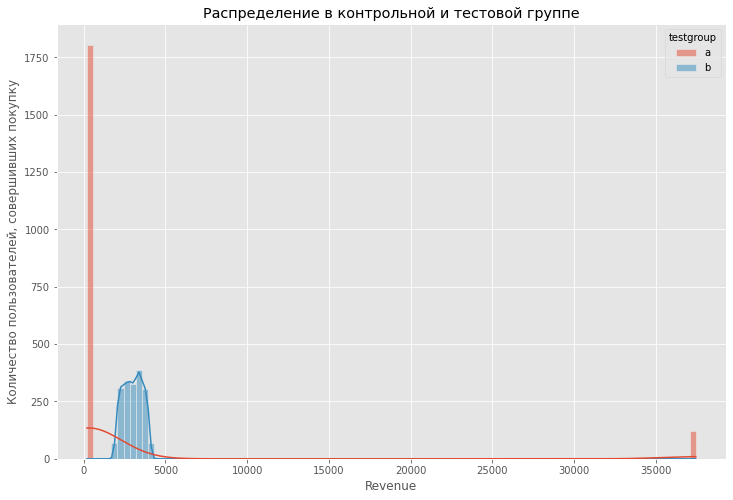

In [48]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=df_1.query('revenue > 0'), 
                  x='revenue', 
                  hue='testgroup', 
                  kde=True, 
                  bins=100)
ax.set(xlabel='Revenue',
       ylabel='Количество пользователей, совершивших покупку',
       title='Распределение в контрольной и тестовой группе')

Оценим боксплоты на всех пользователей и на пользователей, совершивших покупку

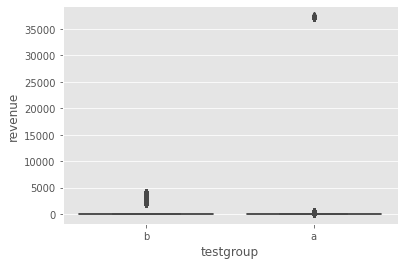

In [49]:
sns.boxplot(x = "testgroup", y = "revenue", data = df_1)

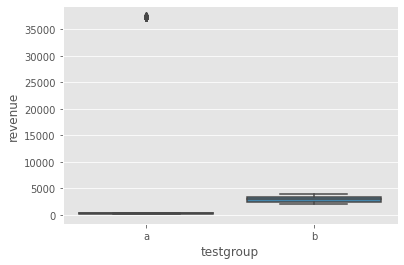

In [50]:
sns.boxplot(x = "testgroup", y = "revenue", data = df_1.query('revenue != 0'))

*По результатам наблюдений можно сделать вывод о том, что в тестовой группе платежи отличаются по сумме покупок от контрольной: в тестовой распределение равномерное, в контрольной большинство платежей с низким чеком, однако есть выбросы с суммой более 30000.*

Проанализируем данные и оценим выбросы в контрольной группе.

In [51]:
control_pays.query('revenue > 30000').agg({'user_id':'count'})

user_id    123
dtype: int64

Обнаружено 123 пользователя с суммой покупки, превышающей 30000. Оценим соотношение таких пользователей и определим, являются ли такие показатели выбросами

In [52]:
diff_control = (control_pays.query('revenue > 30000').shape[0]/control_pays.query('revenue < 30000').shape[0] * 100)
diff_control = int(diff_control) 

print(f'У {diff_control}% игроков сумма покупки превышает 30000')

У 6% игроков сумма покупки превышает 30000


In [53]:
# узнаем общую выручку по группам
df_1.groupby(['testgroup'], as_index=False) \
        .agg({'revenue': 'sum'}) \
        .rename(columns={"revenue": "total_revenue"})

,testgroup,total_revenue
0,a,5136189
1,b,5421603


In [54]:
# напишем функцию, которая расчитает данные по средней выручке на одного пользователя (ARPU), среднюю выручку на одного 
# платящего пользователя (ARPPU) и конверсию в покупку (CR)
def metrics(a, b):

#   ARPU
    arpu_a = (a.revenue.sum() / a.user_id.nunique())
    arpu_b = (b.revenue.sum() / b.user_id.nunique())

#   ARPPU
    arppu_a = (a.revenue.sum() / a.query('revenue > 0').user_id.nunique())
    arppu_b = (b.revenue.sum() / b.query('revenue > 0').user_id.nunique())
    
#   CR
    cr_a = a.query('revenue > 0').user_id.nunique() / a.user_id.nunique()
    cr_b = b.query('revenue > 0').user_id.nunique() / b.user_id.nunique()
    
#   Создадим словарь, из которого получится датафрейм с искомыми метриками
    total = {'arpu': [arpu_a, arpu_b],
             'arppu': [arppu_a, arppu_b],
             'cr': [cr_a, cr_b]}  
    
#   Присвоим значения a и b индексам датафрейма            
    total = pd.DataFrame(total, index=['a', 'b'])
    
    return total

In [55]:
group_a = df_1.query('testgroup == "a"')  # данные контрольной группы

group_b = df_1.query('testgroup == "b"')  # данные тестовой группы

In [56]:
metrics_ab = metrics(group_a, group_b)
metrics_in_style = (metrics_ab
                    .style
                    .set_caption('Key metrics of AB-test')  # добавляем подпись
                    .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам (желтый - больше)
                    .format(formatter={('arpu', 'arppu'): "{:.2f}",
                                       ('cr'): "{:.2%}"}))  # числа в столбце cr форматируем как проценты
metrics_in_style

,arpu,arppu,cr
a,25.413720,2663.998444,0.95%
b,26.751287,3003.658172,0.89%


Мы видим, что ARPU и ARPPU в тестовой группе выше, в то время как конверсия в покупку выше в контрольной группе.

**Проанализируем ARPU**

Из графика распределения выручки в группах было видно, что распределения не являются нормальными.

Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Левена.

Что касается выбросов - проведем тест дважды: на полных данных и на данных контрольной группы без выбросов.

Гипотезы:

- H0 – в генеральной совокупности никакого различия между средними значениями нет

- H1 – средние в генеральной совокупности не равны (альтернативная гипотеза)

In [57]:
pg.homoscedasticity(data = df_1, dv = "revenue", group = "testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


p-value > 0.05, соответственно данные имеют гомогенную дисперсию. Попробуем провести t-test.

In [58]:
stats.ttest_ind(group_a.revenue, group_b.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

p-value > 0.05, значит, отклонить H0 нельзя, то есть по результатам этого теста статистически значимых различий ARPU контрольной и тестовой групп нет.

Проверим данные без выбросов

In [59]:
df_1_clean = df_1.query("revenue < 35000")
group_a_clean = group_a.query("revenue < 35000")

In [60]:
pg.homoscedasticity(data=df_1_clean, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,1400.723139,4.912188e-306,False


Дисперсии не гомогенны, поэтому используем t-критерий Уэлча

In [61]:
stats.ttest_ind(group_a_clean.revenue, group_b.revenue, equal_var=False)

Ttest_indResult(statistic=-37.48854905417036, pvalue=1.529802212310516e-306)

В этом случае также p-value > 0.05, значит отклонить H0 нельзя, то есть по результатам этого теста статистически значимых различий ARPU контрольной и тестовой групп нет.

**Проанализируем ARPU**

Из графика распределения выручки в группах было видно, что распределения не являются нормальными. Проверим гомогенность дисперсий с помощью критерия Левена

Гипотезы:

- H0 – в генеральной совокупности никакого различия между средними значениями нет

- H1 – средние в генеральной совокупности не равны (альтернативная гипотеза)

In [62]:
pg.homoscedasticity(data = df_1.query('revenue != 0'), dv = "revenue", group = "testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


p-value < 0.05, соответственно данные распределены неравномерно, поэтому используем t-критерий Уэлча.

In [63]:
stats.ttest_ind(group_a.query("revenue > 0").revenue, group_b.query("revenue > 0").revenue, 
                equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

p-value > 0.05, значит отклонить H0 нельзя, то есть по результатам этого теста статистически значимых различий ARPPU контрольной и тестовой групп нет.

**Проанализируем CR**

Теперь проверим различия CR при помощи Хи-квадрат.

Гипотезы:

- H0 – различий между тестовой и контрольной группами нет

- H1 – различия между контрольной и тестовой группами есть

In [64]:
stats.chi2_contingency(pd.crosstab(df_1.testgroup, df_1.cr))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

Так как p-value < 0.05, отклоняем H0. Различия между группами статистически значимы

**Результат:** по моему мнению, тестовый набор предложений внедрять не стоит. Нет достоверных данных о том, что он увеличивает целевые метрики. Хотя тестовая группа показала большую общую выручку, чем контрольная (5 421 603 против 5 136 189), по проведенным статистическим тестам, мы видим, что ARPU и ARPPU статистически не различаются в контрольной и тестовой группах, в то время как различия в CR статистически значимы (конверсия была выше в контрольной группе - 0.95% против 0.89% в тестовой группе).

Таким образом, я бы предложила оставит набор предложений, который применяли в контрольной группе.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

*Нам неизвестна структура данных игры, однако мы можем предложить набор метрик, которые гипотетически могут высчитываться на основании данных. Для оценки результатов последнего прошедшего события можно предложить следующие метрики:*

- **Unique players per event** - *количество игроков, которые посетили событие. Данная метрика станет своего рода "контрольной точкой" при сравнении активности игроков на сравниваемых событиях. Чем выше данная метрика, тем успешнее событие*


- **Influx of new players** - *количество новых игроков, пришедших за период события. Данная метрика отражает, насколько хорошо работает рекламная кампания и насколько высок уровен рекомендаций. ЧЕм выше данная метрика, тем успешнее событие*


- **Event Retention** - *количество игроков, вернувшихся после предыдущего события. Данная метрика рассчитывается как отношение вернувшихся игроков ко всем игрокам. Чем выше данная метрика, тем успешнее можно оценить предыдущее событие*


- **Levels Retention** - *количество игроков, переходящих на следующий уровень. Данная метрика показывает прогресс игроков, а также те уровни, которые вызывают наибольшую сложность или вовсе проводят к тому, что игрок "отваливается". Чем выше данная метрика, тем успешнее событие*


- **Retention** - *общее количество вернувшихся игроков. Данная метрика показывает, сколько игроков продолжают играть. Чем выше метрика, тем успешнее событие*


- **Сount of ads** - *количество рекламных кампаний, проведенных за период события. Данная метрика отражает, насколько часто в СМИ встречается упоминание игры и события. Чем выше данная метрика, тем больше поток новых игроков, тем успешнее событие*


- **Count of tags** - *количество упоминаний игры и события в социальных сетях. Данная метрика показывает, насколько игрокам нравится или не нравится данное событие. Чем выше данная метрика (в положительном ключе), тем успешнее событие; чем выше данная метрика (в негативном ключе), тем ниже оценивается успех*


- **Change in market rating** - *изменения в оценке игры в маркете. Данная метрика показывает, на сколько процентов увеличилась или уменьшилась оценка игры на платформе с периода предыдущего события. Если метрика положительная, то рейтинг увеличился и событие успешно; если метрика отрицательная, то рейтинг упал и событие менее успешно*


- **Average amount of time** - *среднее количество времени, проведенное игроком в игре. Рассчитывается за выбранный промежуток времени (событие, день, уровень и др.). Чем выше метрика, тем успешнее событие*


- **Earned coins** - *количество заработанной внутренней валюты в ходе события. Данная метрика показывает, какие бонусы получает игрок в ходе события. Чем выше данная метрика, тем выше мотивация игроков посетить следующее событие*


- **Spended coins** - *количество потраченной внутренней валюты в ходе события. Данная метрика показывает, насколько ресурсозатратным является событие для игрока. Чем выше данная метрика, тем ниже мотивация игрока посетить следующее событие*


- **Trophies** - *количество трофеев и наград, полученных в ходе события. Чем выше данная метрика, тем выше мотивация игроков посетить следующее событие*


- **Revenue** - *объем дохода, полученный по окончанию события. Чем выше метрика, тем успешнее событие*



*После того, как будет введена новая механика, можно будет посмотреть еще несколько метрик, например:*

- **Count of attemps** - *количество попыток игрока пройти уровень. Данная метрика позволить оценить коэффициент отката игрока на уровни назад и в целом отобразить прогресс игрока. Чем выше данная метрика, тем ниже мотивация игрока продолжать играть*


- **Deceleration factor** - *коэффициент замедления игрока. Данная метрика показывает, на сколько меньше уровней игрок стал продвигаться дальше за единицу времени. Чем выше данная метрика, тем ниже прогресс игрока и тем ниже его мотивация* 


- **Failing levels Retention** - *количество игроков, которые возвращаются в игру после проваленного уровня. Чем выше данная метрика, тем выше мотивация игрока*